In [1]:
import calendar

import xarray as xr
from xclim import sdba
import xclim as xc
from clisops.core.subset import subset_bbox
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import numpy as np

In [2]:
hist_files = [
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc',
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc',
]

future_files = [
    '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc',
    '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc',   
]

In [3]:
#Alice Springs
example_lat = -23.7
example_lon = 133.88
point_selection = {'lat': example_lat, 'lon': example_lon}

#Australia
lat_min = -44.5
lat_max = -10.0
lon_min = 112.0
lon_max = 156.25

In [4]:
ds_hist = xr.open_mfdataset(hist_files)
ds_hist = subset_bbox(
    ds_hist,
    start_date='1995-01-01',
    end_date='2014-12-31',
)
ds_hist['pr'] = xc.units.convert_units_to(ds_hist['pr'], 'mm d-1')

In [5]:
ds_hist = ds_hist.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})

In [6]:
ds_future = xr.open_mfdataset(future_files)
ds_future = subset_bbox(ds_future, start_date='2035-01-01', end_date='2064-12-31')
ds_future['pr'] = xc.units.convert_units_to(ds_future['pr'], 'mm d-1')

In [7]:
ds_future = ds_future.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})

## Raw data

In [10]:
#sdba.nbutils.quantile(ds_future['pr'], 100, 'time')

In [8]:
qm = sdba.EmpiricalQuantileMapping.train(
    ds_future['pr'],
    ds_hist['pr'],
    nquantiles=100,
    group="time.month",
    kind='*',
)    

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  ret

In [11]:
qm.ds

<xarray.Dataset>
Dimensions:    (lon: 192, lat: 145, month: 12, quantiles: 100)
Coordinates:
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (lon, lat, month, quantiles) float32 dask.array<chunksize=(64, 29, 12, 100), meta=np.ndarray>
    hist_q     (lon, lat, month, quantiles) float32 dask.array<chunksize=(64, 29, 12, 100), meta=np.ndarray>
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.EmpiricalQuantil...
    adj_params:         EmpiricalQuantileMapping(group=Grouper(add_dims=[], n...

In [12]:
qm.ds = qm.ds.compute()

In [13]:
qm_reverse = sdba.EmpiricalQuantileMapping.train(
    ds_hist['pr'],
    ds_future['pr'],
    nquantiles=100,
    group="time.month",
    kind='*',
)  

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  ret

In [14]:
qm_reverse.ds = qm_reverse.ds.compute()

In [15]:
future_q = qm_reverse.ds['hist_q']

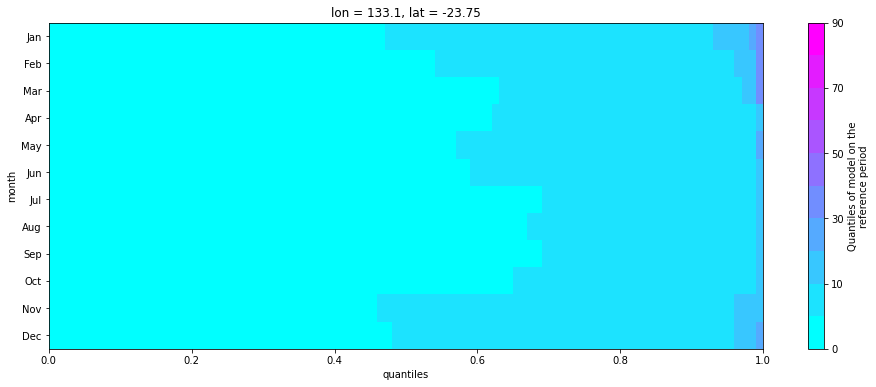

In [18]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = future_q.sel(point_selection, method='nearest')
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
    levels=[0, 0.001, 10, 20, 30, 40, 50, 60, 70, 80, 90],
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()

In [25]:
future_q.sel(point_selection, method='nearest').isel({'month': 8}).values

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [43]:
future_q_problem = future_q.sel(point_selection, method='nearest').isel({'month': 8}).values[59:63]
future_q_problem

array([0.0000000e+00, 4.2747165e-06, 1.8126997e-05, 4.7602538e-05],
      dtype=float32)

In [19]:
hist_q = qm.ds['hist_q']

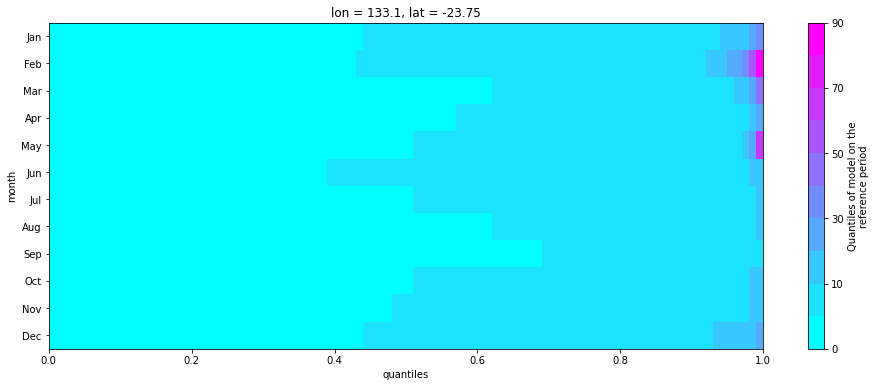

In [21]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = hist_q.sel(point_selection, method='nearest')
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
    levels=[0, 0.001, 10, 20, 30, 40, 50, 60, 70, 80, 90],
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()

In [32]:
hist_q.sel(point_selection, method='nearest').isel({'month': 8}).values

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [44]:
hist_q_problem = hist_q.sel(point_selection, method='nearest').isel({'month': 8}).values[59:63]
hist_q_problem

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.8212996e-06],
      dtype=float32)

In [23]:
af = future_q / hist_q

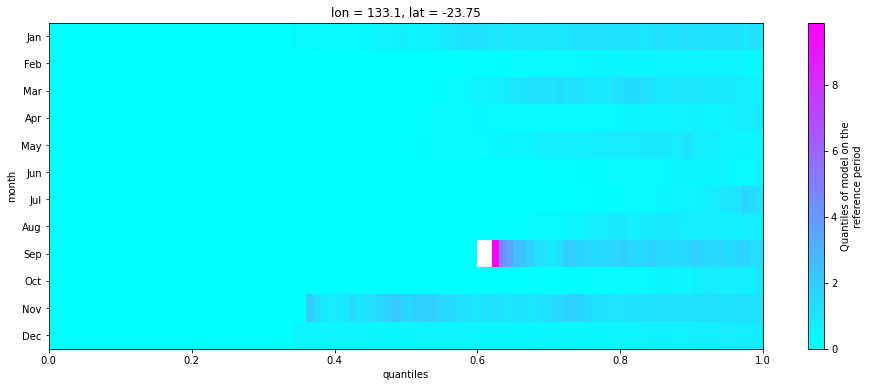

In [24]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = af.sel(point_selection, method='nearest').fillna(0)
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
#    levels=[0, 0.001, 1, 2, 3, 4, 5, 6, 7, 8, 9],
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()

In [34]:
af.sel(point_selection, method='nearest').isel({'month': 8}).values

array([      nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             inf,       inf, 9.873383 , 4.3275695, 3.5339034, 2.5628958,
       2.265144 , 1.7378631, 1.2221994, 1.057881 , 0.9186134, 1.1767849,
       1.8854538, 1.8928564, 1.5851262, 1.6279737, 1.382795 , 1.5570157,
       1.6256266, 1.645102 , 1.8306504, 1.6492003, 

In [45]:
af_problem = af.sel(point_selection, method='nearest').isel({'month': 8}).values[59:63]
af_problem

array([     nan,      inf,      inf, 9.873383], dtype=float32)

In [46]:
future_q_problem

array([0.0000000e+00, 4.2747165e-06, 1.8126997e-05, 4.7602538e-05],
      dtype=float32)

In [47]:
hist_q_problem

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.8212996e-06],
      dtype=float32)

In [48]:
future_q_problem / hist_q_problem

/jobfs/63784589.gadi-pbs/ipykernel_3640087/2796855109.py:1: RuntimeWarning: divide by zero encountered in true_divide
  future_q_problem / hist_q_problem
/jobfs/63784589.gadi-pbs/ipykernel_3640087/2796855109.py:1: RuntimeWarning: invalid value encountered in true_divide
  future_q_problem / hist_q_problem


array([     nan,      inf,      inf, 9.873383], dtype=float32)

In [50]:
np.array([0.0, 1.0]) / np.array([0.0, 0.0])

/jobfs/63784589.gadi-pbs/ipykernel_3640087/1322972040.py:1: RuntimeWarning: divide by zero encountered in true_divide
  np.array([0.0, 1.0]) / np.array([0.0, 0.0])
/jobfs/63784589.gadi-pbs/ipykernel_3640087/1322972040.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.array([0.0, 1.0]) / np.array([0.0, 0.0])


array([nan, inf])

0 divided by 0 is Nan. A number divided by 0 is inf

It becomes problematic if the historical data has more zero quantiles for a given month than the reference data. When you get the first non-zero quantile you end up dividing a relatively large reference value by a relatively small historical value (leading to a large adjustment factor).

In [75]:
hist_ad, pth, dP0 = sdba.processing.adapt_freq(
    ds_future['pr'], ds_hist['pr'], thresh="0.5 mm d-1", group="time.month"
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  ret

In [76]:
hist_ad

<xarray.DataArray 'sim_ad' (lon: 192, lat: 145, time: 18263)>
dask.array<sim_ad-block_group__adapt_freq, shape=(192, 145, 18263), dtype=float32, chunksize=(64, 29, 18263), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2064-12-31T12:00:00
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        pr: 2019-11-15T10:39:53Z altered by CMOR: replaced missin...
    references:     Themeßl et al. (2012), Empirical-statistical downscaling ...

In [77]:
qm_ad = sdba.EmpiricalQuantileMapping.train(
    ds_future['pr'],
    hist_ad,
    nquantiles=100,
    group="time.month",
    kind='*',
)  

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [78]:
qm_ad.ds = qm_ad.ds.compute()

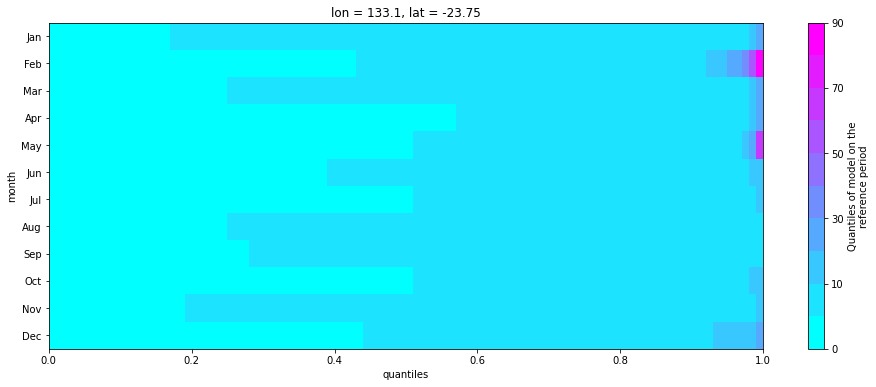

In [79]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = qm_ad.ds['hist_q'].sel(point_selection, method='nearest')
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
    levels=[0, 0.001, 10, 20, 30, 40, 50, 60, 70, 80, 90],
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()

In [80]:
af_ad = future_q / qm_ad.ds['hist_q']

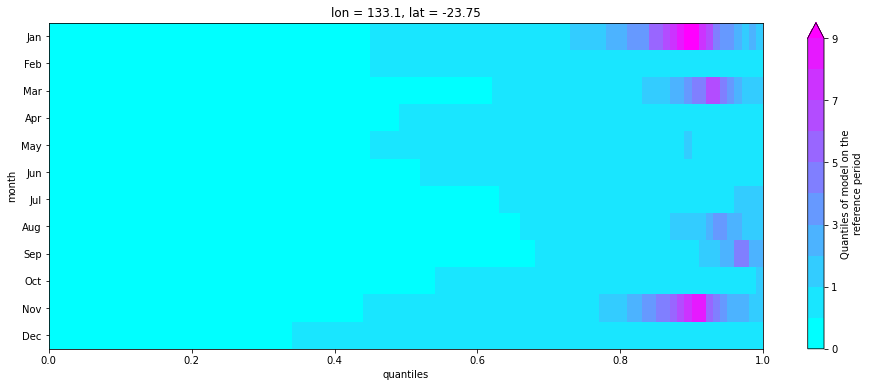

In [81]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = af_ad.sel(point_selection, method='nearest').fillna(0)
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
    levels=[0, 0.001, 1, 2, 3, 4, 5, 6, 7, 8, 9],
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()

In [60]:
af_ad.sel(point_selection, method='nearest').isel({'month': 8}).values

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

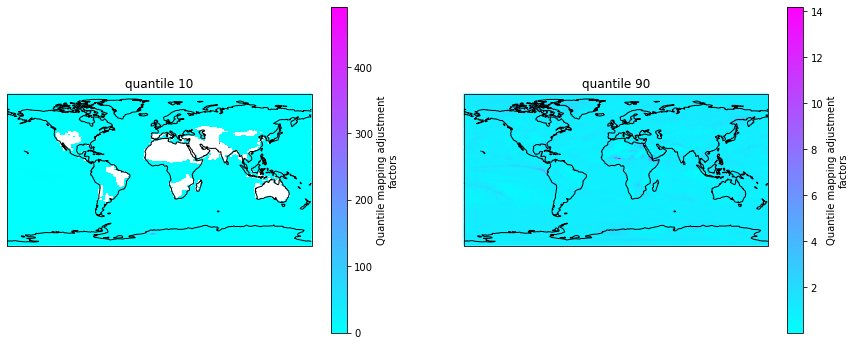

In [11]:
fig = plt.figure(figsize=[15, 6])
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qm.ds['af'].isel({'quantiles': 10, 'month': 9}).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
qm.ds['af'].isel({'quantiles': 90, 'month': 9}).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
ax1.set_title('quantile 10')
ax2.set_title('quantile 90')
ax1.coastlines()
ax2.coastlines()
plt.show()

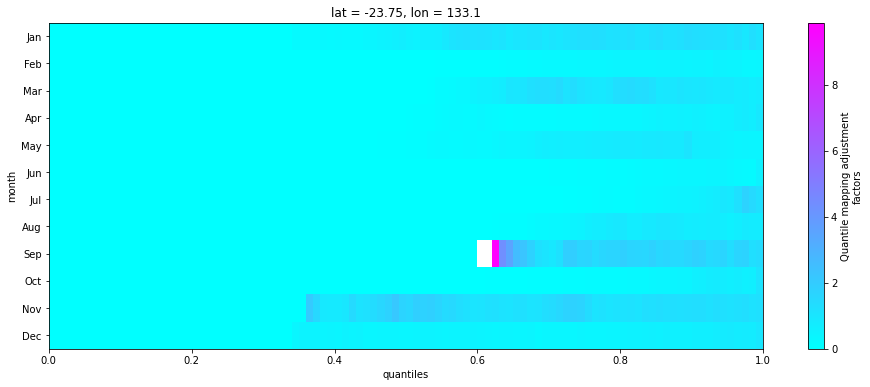

In [23]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = qm.ds['af'].sel(point_selection, method='nearest').fillna(0)
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
#    levels=[0, 0.001, 1, 2, 3, 4, 5, 6, 7, 8, 9],
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()

In [30]:
qm.ds['af'].sel(point_selection, method='nearest').isel({'month': 8}).values[60:63]

array([     inf,      inf, 9.873383], dtype=float32)

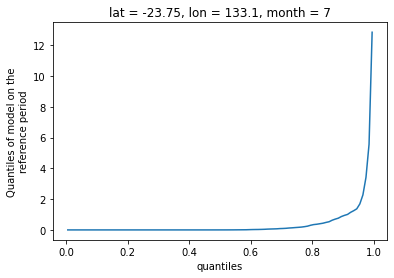

In [20]:
qm.ds['hist_q'].sel(point_selection, method='nearest').isel({'month': 6}).plot()

In [17]:
qm.ds['hist_q'].sel(point_selection, method='nearest').isel({'month': 6}).values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.56795578e-06,
       1.38591931e-05, 4.47627390e-05, 1.01771606e-04, 2.58359389e-04,
       3.61245126e-04, 6.90954563e-04, 8.89131159e-04, 1.12698728e-03,
       1.56152144e-03, 2.32378324e-03, 3.57385445e-03, 5.24746627e-03,
      

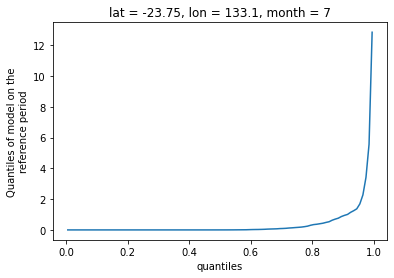

In [16]:
qm.ds['hist_q'].sel(point_selection, method='nearest').isel({'month': 6}).plot()

In [101]:
ds_hist['pr'].sel(point_selection, method='nearest').values.max()

131.02338

In [102]:
ds_hist['pr'].sel(point_selection, method='nearest').values.min()

-7.940934e-21

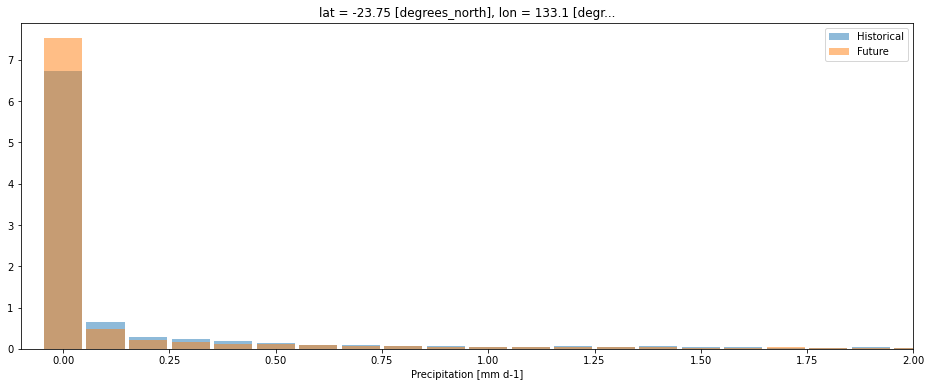

In [118]:
fig, ax = plt.subplots(figsize=[16, 6])

bins = np.arange(-0.05, 132, 0.1)

hist_plot = ds_hist['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:blue',
    label='Historical',
)

future_plot = ds_future['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:orange',
    label='Future',
)

plt.legend()
ax.set_xlim(-0.1, 2)
plt.show()

To reduce the risk of sharp change in the adjustment at the interface of the months, interp='linear' can be passed to adjust and the adjustment factors will be interpolated linearly. Ex: the factors for the 1st of May will be the average of those for april and those for may.

```python
scen = QM_mo.adjust(sim, extrapolation="constant", interp="linear")
```

In [ ]:
#qm.ds = qm.ds.assign_coords({'lat': ds_future['lat'], 'lon': ds_future['lon']}) #xclim strips lat/lon attributes
#qm.ds = qm.ds.transpose('quantiles', 'month', 'lat', 'lon')

## Adapt frequency


See https://xclim.readthedocs.io/en/stable/notebooks/sdba.html#First-example-:-pr-and-frequency-adaptation

```python
# 2nd try with adapt_freq
sim_ad, pth, dP0 = sdba.processing.adapt_freq(
    pr_ref, pr_sim, thresh="0.05 mm d-1", group="time"
)
QM_ad = sdba.EmpiricalQuantileMapping.train(
    pr_ref, sim_ad, nquantiles=15, kind="*", group="time"
)
```

In [88]:
future_ad, pth, dP0 = sdba.processing.adapt_freq(
    ds_hist['pr'], ds_future['pr'], thresh="0.5 mm d-1", group="time"
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  ret

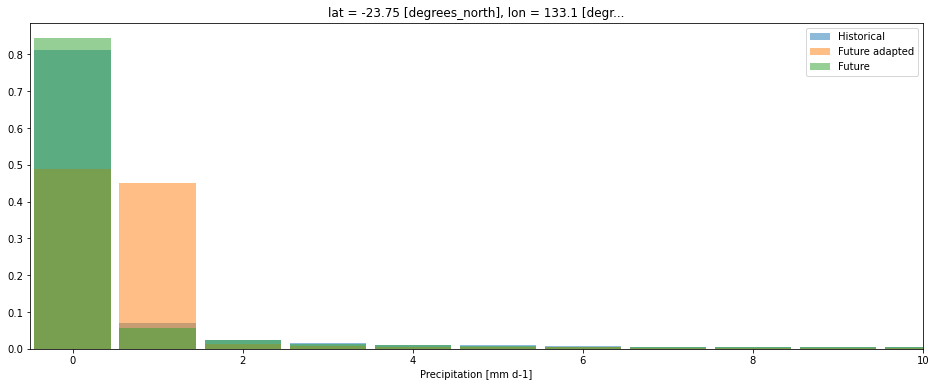

In [89]:
fig, ax = plt.subplots(figsize=[16, 6])

bins = np.arange(-0.5, 132, 1)

hist_plot = ds_hist['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:blue',
    label='Historical',
)

future_ad_plot = future_ad.sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:orange',
    label='Future adapted',
)

future_plot = ds_future['pr'].sel(point_selection, method='nearest').plot.hist(
    ax=ax,
    bins=bins,
    density=True,
    rwidth=0.9,
    alpha=0.5,
    color='tab:green',
    label='Future',
)

plt.legend()
ax.set_xlim(-0.5, 10)
plt.show()

In [75]:
qm_ad = sdba.EmpiricalQuantileMapping.train(
    future_ad,
    ds_hist['pr'],
    nquantiles=100,
    group="time.month",
    kind='*',
)   

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [76]:
qm_ad.ds

<xarray.Dataset>
Dimensions:    (lat: 145, lon: 192, month: 12, quantiles: 100)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (lat, lon, month, quantiles) float32 dask.array<chunksize=(29, 64, 12, 100), meta=np.ndarray>
    hist_q     (lat, lon, month, quantiles) float32 dask.array<chunksize=(29, 64, 12, 100), meta=np.ndarray>
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.EmpiricalQuantil...
    adj_params:         EmpiricalQuantileMapping(group=Grouper(add_dims=[], n...

In [77]:
qm_ad.ds = qm_ad.ds.compute()

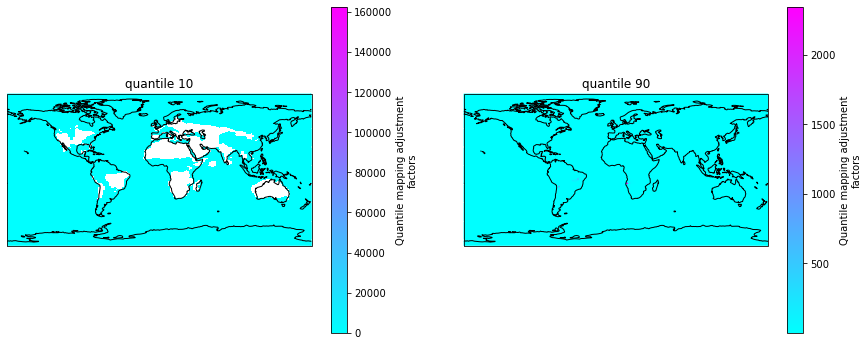

In [78]:
fig = plt.figure(figsize=[15, 6])
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qm_ad.ds['af'].isel({'quantiles': 10, 'month': 5}).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
qm_ad.ds['af'].isel({'quantiles': 90, 'month': 5}).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
#    cmap=cmocean.cm.rain,
    cmap='cool'
)
ax1.set_title('quantile 10')
ax2.set_title('quantile 90')
ax1.coastlines()
ax2.coastlines()
plt.show()

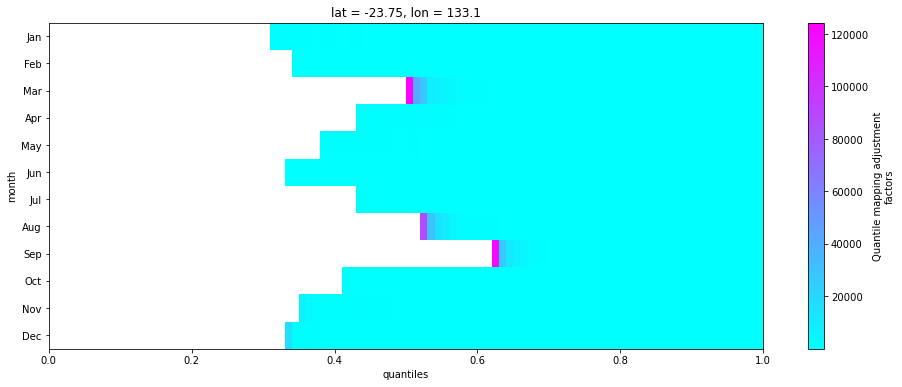

In [79]:
fig, ax = plt.subplots(figsize=[16, 6])
quantiles = qm_ad.ds['af'].sel(point_selection, method='nearest')
quantiles.transpose('month', 'quantiles').plot(
    cmap='cool',
)
yticks = np.arange(1,13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
plt.yticks(yticks, ytick_labels)
ax.invert_yaxis()
plt.show()